# Exploratory Data Analysis

## What's provided ?

### Target

Show representations of the dataset through univariate and multivariate analysis

main interesting feature are:
* nutriscore_score
* nutriscore_grade

### Size / Nb lines & columns

Data set contains 186 columns and approx 2Mio lignes

### Types of features / variables

it contains a mix of types : dates, strings, numbers

Interesting ones:

#### Qualitative
* countries_tags
* allergens
* traces
* additives
* pnns_groups_1 [explanation (fr)](https://solidarites-sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* pnns_groups_2
* nova_group [explanation (fr)](https://www.thierrysouccar.com/nutrition/info/nova-une-classification-des-aliments-basee-sur-la-science-3936)
* brand_owner ?
* main_category

#### Quantitative
* serving_size
* serving_quantity
* no_nutriments
* additives_n
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n
* nutriscore_score
* nutriscore_grade
* ecoscore_score_fr
* ecoscore_grade_fr

Detailed variables :

* energy-kj_100g
* energy-kcal_100g
* energy_100g
* energy-from-fat_100g
* fat_100g
* saturated-fat_100g
* -butyric-acid_100g
* -caproic-acid_100g
* -caprylic-acid_100g
* -capric-acid_100g
* -lauric-acid_100g
* -myristic-acid_100g
* -palmitic-acid_100g
* -stearic-acid_100g
* -arachidic-acid_100g
* -behenic-acid_100g
* -lignoceric-acid_100g
* -cerotic-acid_100g
* -montanic-acid_100g
* -melissic-acid_100g
* monounsaturated-fat_100g
* polyunsaturated-fat_100g
* omega-3-fat_100g
* -alpha-linolenic-acid_100g
* -eicosapentaenoic-acid_100g
* -docosahexaenoic-acid_100g
* omega-6-fat_100g
* -linoleic-acid_100g
* -arachidonic-acid_100g
* -gamma-linolenic-acid_100g
* -dihomo-gamma-linolenic-acid_100g
* omega-9-fat_100g
* -oleic-acid_100g
* -elaidic-acid_100g
* -gondoic-acid_100g
* -mead-acid_100g
* -erucic-acid_100g
* -nervonic-acid_100g
* trans-fat_100g
* cholesterol_100g
* carbohydrates_100g
* sugars_100g
* -sucrose_100g
* -glucose_100g
* -fructose_100g
* -lactose_100g
* -maltose_100g
* -maltodextrins_100g
* starch_100g
* polyols_100g
* fiber_100g
* -soluble-fiber_100g
* -insoluble-fiber_100g
* proteins_100g
* casein_100g
* serum-proteins_100g
* nucleotides_100g
* salt_100g
* sodium_100g
* alcohol_100g
* vitamin-a_100g
* beta-carotene_100g
* vitamin-d_100g
* vitamin-e_100g
* vitamin-k_100g
* vitamin-c_100g
* vitamin-b1_100g
* vitamin-b2_100g
* vitamin-pp_100g
* vitamin-b6_100g
* vitamin-b9_100g
* folates_100g
* vitamin-b12_100g
* biotin_100g
* pantothenic-acid_100g
* silica_100g
* bicarbonate_100g
* potassium_100g
* chloride_100g
* calcium_100g
* phosphorus_100g
* iron_100g
* magnesium_100g
* zinc_100g
* copper_100g
* manganese_100g
* fluoride_100g
* selenium_100g
* chromium_100g
* molybdenum_100g
* iodine_100g
* caffeine_100g
* taurine_100g
* ph_100g
* fruits-vegetables-nuts_100g
* fruits-vegetables-nuts-dried_100g
* fruits-vegetables-nuts-estimate_100g
* collagen-meat-protein-ratio_100g
* cocoa_100g
* chlorophyl_100g
* carbon-footprint_100g
* carbon-footprint-from-meat-or-fish_100g
* nutrition-score-fr_100g
* nutrition-score-uk_100g
* glycemic-index_100g
* water-hardness_100g
* choline_100g
* phylloquinone_100g
* beta-glucan_100g
* inositol_100g
* carnitine_100g

### Missing values identification

What are the features which have lots of NaN / empty values ?


## What's in it ?

* Target visualisation (hist, boxplot)

* Features comprehension

* Features - target relations

* Outliers recognition

In [1]:
import numpy as np
# import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
import modin.pandas as pd

In [2]:
df = pd.read_csv('input/open-food-facts/en.openfoodfacts.org.products.csv', sep='\t')

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [3]:
df_bck = df.copy()

In [4]:
df.shape

(1988476, 186)

In [5]:
pd.set_option('display.max_columns', None)
df.head()


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.describe()

,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,additives,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,1.988476e+06,1.988476e+06,0.0,0.0,4.975140e+05,0.0,722441.000000,0.0,722441.000000,0.0,722441.000000,486.000000,11867.000000,719224.000000,8.000000,4.000000,1.0,63.000000,1712.000000,38.000000,69.000000,39.000000
mean,1.560070e+09,1.595301e+09,NaN,NaN,2.233335e+16,NaN,2.029187,NaN,0.020294,NaN,0.070213,267.683060,615.324945,9.103861,13.875000,34.175000,9100.0,3.238417,0.068921,3.278158,2.201766,0.025676
std,5.296541e+07,3.116836e+07,NaN,NaN,1.575269e+19,NaN,2.899762,NaN,0.142943,NaN,0.303937,754.901079,6082.140585,8.842205,8.576338,15.620153,NaN,18.705382,1.826776,1.562956,12.669790,0.090002
min,1.328021e+09,1.333873e+09,NaN,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.049000,-15.000000,1.000000,14.000000,9100.0,0.000000,0.000000,0.400000,0.001350,0.000800
25%,1.524120e+09,1.582759e+09,NaN,NaN,2.800000e+01,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,107.800000,1.000000,8.250000,26.000000,9100.0,0.056500,0.000008,2.450000,0.010000,0.007050
50%,1.571243e+09,1.599393e+09,NaN,NaN,5.300000e+01,NaN,1.000000,NaN,0.000000,NaN,0.000000,100.000000,328.500000,10.000000,15.500000,37.000000,9100.0,0.073600,0.000023,3.600000,0.025000,0.011000
75%,1.603225e+09,1.619531e+09,NaN,NaN,1.133981e+02,NaN,3.000000,NaN,0.000000,NaN,0.000000,286.925000,614.200000,16.000000,22.000000,45.175000,9100.0,0.125000,0.000096,4.000000,0.047000,0.015000
max,1.634172e+09,1.634172e+09,NaN,NaN,1.111111e+22,NaN,49.000000,NaN,3.000000,NaN,6.000000,13867.000000,656298.600000,40.000000,22.000000,48.700000,9100.0,136.000000,54.000000,7.300000,75.000000,0.572000


In [7]:
# les types de features
# todo afficher la full liste
df.dtypes

code                   object
url                    object
creator                object
created_t               int64
created_datetime       object
                       ...   
choline_100g          float64
phylloquinone_100g    float64
beta-glucan_100g      float64
inositol_100g         float64
carnitine_100g        float64
Length: 186, dtype: object

<AxesSubplot:ylabel='None'>

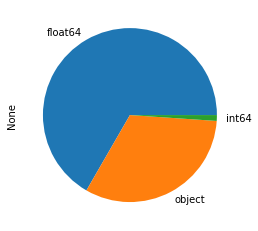

In [8]:
# nombre de features selon leur type
df.dtypes.value_counts().plot.pie()

In [18]:
nb_rows = df.shape[0]

In [35]:
pd.set_option('display.max_rows', None)

In [36]:
(df.isna().sum()/nb_rows).sort_values()

code                                     0.000000
states_en                                0.000000
states                                   0.000000
last_modified_datetime                   0.000000
last_modified_t                          0.000000
states_tags                              0.000000
created_t                                0.000000
url                                      0.000000
created_datetime                         0.000000
creator                                  0.000002
pnns_groups_2                            0.000098
pnns_groups_1                            0.000099
countries                                0.003076
countries_en                             0.003078
countries_tags                           0.003078
product_name                             0.041016
energy_100g                              0.206648
proteins_100g                            0.210012
fat_100g                                 0.210630
carbohydrates_100g                       0.210811


features kept :

|feature|is nan%| keep ? |
|-----|-----|-----|
|code                                     |0.000000|Yes
|states_en                                |0.000000|
|states                                   |0.000000|
|last_modified_datetime                   |0.000000|
|last_modified_t                          |0.000000|
|states_tags                              |0.000000|
|created_t                                |0.000000|
|url                                      |0.000000|
|created_datetime                         |0.000000|
|creator                                  |0.000002|
|pnns_groups_2                            |0.000098|Yes
|pnns_groups_1                            |0.000099|Yes
|countries                                |0.003076|
|countries_en                             |0.003078|
|countries_tags                           |0.003078|
|product_name                             |0.041016|
|energy_100g                              |0.206648|Yes
|proteins_100g                            |0.210012|Yes
|fat_100g                                 |0.210630|Yes
|carbohydrates_100g                       |0.210811|Yes
|sugars_100g                              |0.218672|Yes
|saturated-fat_100g                       |0.232296|Yes
|energy-kcal_100g                         |0.232480|Yes
|image_url                                |0.233248|
|image_small_url                          |0.233248|
|salt_100g                                |0.252245|Yes
|sodium_100g                              |0.252247|Yes
|brands_tags                              |0.483326|Yes

TODO : complete list is not sync w/ following command

In [37]:
# filter out columns that have more than 80 % of empty values
threshold = 0.8
df = df[df.columns[df.isna().sum()/nb_rows < threshold]]

In [39]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,brands_tags,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.1,0.04,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.4,0.56,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,NaN,163.9,685.8,1.9,1.00,NaN,NaN,NaN,15.3,1.1,0.44,NaN


In [41]:
df = df.drop({'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime' }, axis=1)

ValueError: labels ['created_t', 'created_datetime', 'creator', 'url', 'last_modified_datetime', 'last_modified_t'] not contained in axis

In [43]:
df = df.drop({'image_url',
              'image_small_url', 'image_ingredients_url',
              'image_ingredients_small_url', 'image_nutrition_url',
              'image_nutrition_small_url' }, axis=1)

(compute_sliced_len pid=427016) 


In [44]:
df.columns

Index(['code', 'product_name', 'quantity', 'brands', 'brands_tags',
       'categories', 'categories_tags', 'categories_en', 'labels',
       'labels_tags', 'labels_en', 'countries', 'countries_tags',
       'countries_en', 'ingredients_text', 'serving_size', 'serving_quantity',
       'additives_n', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'states_tags', 'states_en', 'ecoscore_score_fr',
       'ecoscore_grade_fr', 'main_category', 'main_category_en',
       'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [46]:
pd.set_option('display.max_columns', None)
df.head()

,code,product_name,quantity,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.1,0.04,NaN
2,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.4,0.56,NaN
3,0000000000031,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.9,685.8,1.9,1.00,NaN,NaN,NaN,15.3,1.1,0.44,NaN


We now have a dataset with only 45 columns left

In [54]:
df['nutriscore_grade'].value_counts(normalize=True)

d    0.311174
c    0.215195
e    0.183622
a    0.159760
b    0.130250
Name: nutriscore_grade, dtype: float64

<AxesSubplot:>

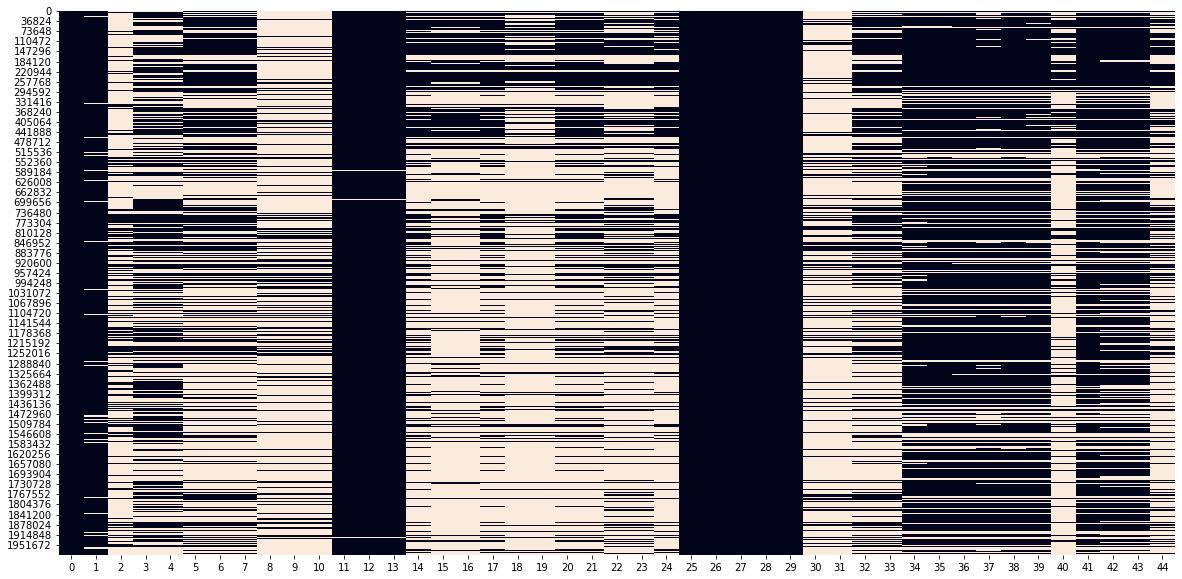

In [55]:
#trouver ou sont colones avec le plus de valeurs manquantes
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

OLD

In [9]:
df.drop(labels=['image_url',
                'image_small_url',
                'image_ingredients_url',
                'image_ingredients_small_url',
                'image_nutrition_url',
                'image_nutrition_small_url'], axis=1, inplace=True)
df.shape


(1988476, 180)

In [14]:
df.fillna(0, inplace=True)

In [38]:
# df[df['nutriscore_score'] > 0][{'nutriscore_score', 'countries'}]
df[df['nutriscore_score'] > 0]['nutriscore_score'].unique()

array([18.,  1., 14.,  4., 15., 17., 21.,  2.,  3., 29.,  6., 22., 11.,
        9.,  5., 28., 23., 20., 12., 16., 26., 19., 24., 13., 36., 27.,
       10.,  7.,  8., 25., 30., 33., 38., 31., 34., 39., 35., 32., 40.,
       37.])

In [71]:
# df['countries'].unique().reshape(10767,1)
lower = df['countries']\
    .map(lambda value: str(value).lower())
lower

'en:france'['en:france'.find(':')+1:len('en:france')]
#
# lower_clean = lower.map(lambda value:
#                         print(value)
#                         # print(value.find(':'))
#                         # value[value.find(':')+1,len(value)]
#                         )
# lower_clean


'france'

In [ ]:
columns = set([x for lst in df['categories_tags'] for x in lst.split(",")])
for col in columns:
    df[col] = ""*len(df)

for i, val in enumerate(df["Class"]):
    cl = val.replace(" ", "").split(",")
    print(cl)
    for value in cl:
        df.loc[i][value] = value
df.drop('Class', axis=1, inplace=True)

In [51]:
df[{'categories_tags', 'countries_tags'}]

0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
               ...      
1988471              NaN
1988472              NaN
1988473              NaN
1988474              NaN
1988475    en:toothpaste
Name: main_category, Length: 1988476, dtype: object

In [56]:
df.groupby('main_category')['code'].nunique()
df.value_counts()

Series([], dtype: int64)